## Single step test

Works with the new dataset(s), which have smaller gaps between timesteps


In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import sys
import pickle
import copy
import os

import torch
import math
import numpy as np
import wandb
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

import pyqg_explorer.dataset.forcing_dataset as forcing_dataset
import pyqg_explorer.models.base_model as base_model
import pyqg_explorer.util.pbar as pbar
import pyqg_explorer.util.transforms as transforms
import pyqg_explorer.util.divergence_dataset as divergence_dataset
import pyqg_explorer.util.powerspec as powerspec

from sklearn.metrics import r2_score

/home/cp3759/Projects/pyqg_experiments/pyqg_subgrid_experiments/__init__.py:19: UserWarning: Unable to load differentiable_parameterizations, install autograd if you want to use these
  warnings.warn("Unable to load differentiable_parameterizations, install autograd if you want to use these")


In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Available


In [3]:
lev="both"
forcing=1
seed=123
batch_size=64
input_channels=2
output_channels=2
activation="ReLU"
arch="cnn_theta"
epochs=3
subsample=None
normalise="proper"
beta_steps=5
beta_loss=1000
save_path="/scratch/cp3759/pyqg_data/models"
save_name="cnn_theta_beta%d_betaloss%d_forcing%d_both_epoch%d.pt" % (beta_steps,beta_loss,forcing,epochs)
lr=0.0001

## Wandb config file
config={"lev":lev,
        "forcing":forcing,
        "seed":seed,
        "lr":lr,
        "batch_size":batch_size,
        "input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "save_name":save_name,
        "save_path":save_path,
        "arch":arch,
        "beta_steps":beta_steps,
        "beta_loss":beta_loss,
        "epochs":epochs,
        "subsample":subsample,
        "normalise":normalise}

In [4]:
single_dataset=forcing_dataset.TimestepDatasetBoth('/scratch/cp3759/pyqg_data/sims/%d_step/all.nc' % config["beta_steps"],normalise=config["normalise"],subsample=config["subsample"])

In [5]:
config["q_mean_upper"]=single_dataset.q_mean_upper
config["q_mean_lower"]=single_dataset.q_mean_lower
config["q_std_upper"]=single_dataset.q_std_upper
config["q_std_lower"]=single_dataset.q_std_lower
config["s_mean_upper"]=single_dataset.s_mean_upper
config["s_mean_lower"]=single_dataset.s_mean_lower
config["s_std_upper"]=single_dataset.s_std_upper
config["s_std_lower"]=single_dataset.s_std_lower
config["training_fields"]=len(single_dataset.test_idx)
config["validation_fields"]=len(single_dataset.valid_idx)

config_beta=copy.deepcopy(config)
config_beta["input_channels"]=config["input_channels"]*3
config_beta["save_name"]="cnn_beta%d_betaloss%d_both_epoch%d.pt" % (beta_steps,beta_loss,epochs)
config_beta["arch"]="cnn_beta"

In [6]:
train_loader = DataLoader(
    single_dataset,
    batch_size=config["batch_size"],
    sampler=SubsetRandomSampler(single_dataset.train_idx),
)
valid_loader = DataLoader(
    single_dataset,
    batch_size=config["batch_size"],
    sampler=SubsetRandomSampler(single_dataset.valid_idx),
)

In [7]:
model_theta=base_model.AndrewCNN(config)
model_beta=base_model.AndrewCNN(config_beta)

model_theta.to(device)
model_beta.to(device)

config["theta learnable parameters"]=sum(p.numel() for p in model.parameters())

wandb.init(project="pyqg_betanetwork", entity="chris-pedersen",config=config)
wandb.watch([model_theta,model_beta], log_freq=1)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chris-pedersen. Use `wandb login --relogin` to force relogin


[]

In [10]:
# optimizer parameters
beta1 = 0.5
beta2 = 0.999
lr = config["lr"]
wd = 0.001

optimizer = torch.optim.AdamW(list(model_theta.parameters()) + list(model_beta.parameters()), lr=lr, weight_decay=wd, betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

criterion=nn.MSELoss()

In [ ]:
x_data,y_data=next(iter(train_loader))

In [ ]:
x_data=x_data.to(device)
y_data=y_data.to(device)

## zero the parameter gradients
optimizer.zero_grad()

## First network
output_theta = model_theta(x_data[:,0:2,:,:]) ## Takes in Q, outputs \hat{S}
## Second network
## Takes in Q, F, \hat{S}, outputs \hat{Q_{i+1}}
output_beta = model_beta(torch.cat((x_data[:,0:4,:,:],output_theta),1))

loss_1 = criterion(output_theta, x_data[:,4:6,:,:])
loss_2 = beta_loss*criterion(output_beta, y_data)
loss = loss_1+loss_2
loss.backward()

In [ ]:
model_beta.named_parameters()

In [ ]:
name, param=next(model_beta.named_parameters())
print(name)#,param.grad)

In [ ]:
norms=torch.linalg.vector_norm(param.grad,dim=(0,2,3)).detach()

In [ ]:
grad_norms=torch.zeros(6).to(device)

In [ ]:
grad_norms/=3

In [ ]:
grad_norms

In [8]:
def get_filter_grads(model):
    ## Get parameters of first layer
    name, param=next(model.named_parameters())
    torch.linalg.vector_norm(param.grad,dim=(0,2,3))
    norms=torch.linalg.vector_norm(param.grad,dim=(0,2,3)).detach()
    return norms
"""
    grad_dict={}
    grad_dict["q_upper_grad"]=norms[0]
    grad_dict["q_lower_grad"]=norms[1]
    grad_dict["f_upper_grad"]=norms[2]
    grad_dict["f_lower_grad"]=norms[3]
    grad_dict["theta_upper_grad"]=norms[4]
    grad_dict["theta_lower_grad"]=norms[5]
    return grad_dict
"""

'\n    grad_dict={}\n    grad_dict["q_upper_grad"]=norms[0]\n    grad_dict["q_lower_grad"]=norms[1]\n    grad_dict["f_upper_grad"]=norms[2]\n    grad_dict["f_lower_grad"]=norms[3]\n    grad_dict["theta_upper_grad"]=norms[4]\n    grad_dict["theta_lower_grad"]=norms[5]\n    return grad_dict\n'

In [11]:
for epoch in range(config["epochs"]):  # loop over the dataset multiple times

    train_samples = 0.0
    train_running_loss = 0.0
    train_beta_running_loss = 0.0
    train_theta_running_loss = 0.0
    
    grad_norms=torch.zeros(6).to(device)

    valid_running_loss = 0.0
    valid_beta_running_loss = 0.0
    valid_theta_running_loss = 0.0
    valid_samples = 0.0
    
    model_theta.train()
    model_beta.train()
    
    for i, data in enumerate(train_loader, 0):
        ## x_data is ordered in [pv, dqdt, s]
        x_data, y_data = data
        x_data=x_data.to(device)
        y_data=y_data.to(device)
    
        ## zero the parameter gradients
        optimizer.zero_grad()

        ## First network
        output_theta = model_theta(x_data[:,0:2,:,:]) ## Takes in Q, outputs \hat{S}
        ## Second network
        ## Takes in Q, F, \hat{S}, outputs \hat{Q_{i+1}}
        output_beta = model_beta(torch.cat((x_data[:,0:4,:,:],output_theta),1))
        
        loss_1 = criterion(output_theta, x_data[:,4:6,:,:])
        loss_2 = beta_loss*criterion(output_beta, y_data)
        loss = loss_1+loss_2
        loss.backward()
        
        grad_norms+=get_filter_grads(model_beta)
        optimizer.step()
        
        
        ## Track loss for wandb
        train_running_loss+=loss.detach()
        train_theta_running_loss+=loss_1.detach()
        train_beta_running_loss+=loss_2.detach()
        train_samples+=x_data.shape[0]
        
        #print(train_running_loss)
    
    model_theta.eval()
    model_beta.eval()
    for i, data in enumerate(valid_loader, 0):
        ## x_data is ordered in [pv, dqdt, s]
        x_data, y_data = data
        x_data=x_data.to(device)
        y_data=y_data.to(device)
    
        ## zero the parameter gradients
        optimizer.zero_grad()

        ## First network
        output_theta = model_theta(x_data[:,0:2,:,:]) ## Takes in Q, outputs \hat{S}
        ## Second network
        ## Takes in Q, F, \hat{S}, outputs \hat{Q_{i+1}}
        output_beta = model_beta(torch.cat((x_data[:,0:4,:,:],output_theta),1))
        
        val_loss_1 = criterion(output_theta, x_data[:,4:6,:,:])
        val_loss_2 = beta_loss*criterion(output_beta, y_data)
        val_loss = val_loss_1+val_loss_2
        ## Track loss for wandb
        valid_running_loss+=val_loss.detach()
        valid_samples+=x_data.shape[0]
        valid_theta_running_loss+=val_loss_1.detach()
        valid_beta_running_loss+=val_loss_2.detach()
    
    ## Push loss values for each epoch to wandb
    log_dic={}
    log_dic["epoch"]=epoch
    log_dic["training_loss"]=train_running_loss/train_samples
    log_dic["training_theta_loss"]=train_theta_running_loss/train_samples
    log_dic["training_beta_loss"]=train_beta_running_loss/train_samples
    log_dic["valid_loss"]=valid_running_loss/valid_samples
    log_dic["valid_theta_loss"]=valid_theta_running_loss/valid_samples
    log_dic["valid_beta_loss"]=valid_beta_running_loss/valid_samples
    ## Track filter gradient norms
    grad_norms/=train_samples
    log_dic["q_upper_grad"]=grad_norms[0]
    log_dic["q_lower_grad"]=grad_norms[1]
    log_dic["f_upper_grad"]=grad_norms[2]
    log_dic["f_lower_grad"]=grad_norms[3]
    log_dic["theta_upper_grad"]=grad_norms[4]
    log_dic["theta_lower_grad"]=grad_norms[5]
    wandb.log(log_dic)
    
    # verbose
    print('%03d %.3e %.3e '%(log_dic["epoch"], log_dic["training_loss"], log_dic["valid_loss"]), end='')
    print("")
    

000 1.566e+00 4.757e-01 
001 3.147e-01 2.235e-01 
002 1.821e-01 1.480e-01 


In [ ]:
model_theta.save_model()
model_beta.save_model()

In [12]:
x_maps=torch.tensor(()).to("cpu")
y_true=torch.tensor(()).to("cpu")
y_pred=torch.tensor(()).to("cpu")

model_theta.eval()
model_theta.to("cpu")
model_beta.to("cpu")

for i, data in enumerate(valid_loader, 0):
    ## x_data is ordered in [pv, dqdt, s]
    x_data, y_data = data
    #print(x_data.device)
    #x_data=x_data.to(device)

    ## zero the parameter gradients
    optimizer.zero_grad()

    ## First network
    y_hat = model_theta(x_data[:,0:2,:,:]) ## Takes in PV, outputs S
    
    x_data_cpu=x_data.to("cpu")
    y_hat_cpu=y_hat.to("cpu")
    
    del x_data
    del y_hat
    
    x_maps=torch.cat((x_maps,x_data_cpu[:,0:2,:,:]),dim=0)
    y_true=torch.cat((y_true,x_data_cpu[:,4:6,:,:]),dim=0)
    y_pred=torch.cat((y_pred,y_hat_cpu),dim=0)

In [13]:
## Convert validation fields to numpy arrays
x_np=x_maps.squeeze().cpu().detach().numpy()
y_np=y_true.squeeze().cpu().detach().numpy()
y_pred_np=y_pred.squeeze().cpu().detach().numpy()

## Estimate R2
r2_upper=r2_score(y_np[:,0,:,:].flatten(),y_pred_np[:,0,:,:].flatten())
r2_lower=r2_score(y_np[:,1,:,:].flatten(),y_pred_np[:,1,:,:].flatten())

## Get power spectrum from validation set
power_true_upper=[]
power_pred_upper=[]
power_true_lower=[]
power_pred_lower=[]

for aa in range(len(x_np)):
    power_true_upper.append(powerspec.get_power_spectrum(y_np[aa][0]))
    power_pred_upper.append(powerspec.get_power_spectrum(y_pred_np[aa][0]))
    power_true_lower.append(powerspec.get_power_spectrum(y_np[aa][1]))
    power_pred_lower.append(powerspec.get_power_spectrum(y_pred_np[aa][1]))
    
power_true_upper_mean=np.mean(np.stack(power_true_upper,axis=1),axis=1)
power_pred_upper_mean=np.mean(np.stack(power_pred_upper,axis=1),axis=1)
power_true_upper_err=np.std(np.stack(power_true_upper,axis=1),axis=1)
power_pred_upper_err=np.std(np.stack(power_pred_upper,axis=1),axis=1)

power_true_lower_mean=np.mean(np.stack(power_true_lower,axis=1),axis=1)
power_pred_lower_mean=np.mean(np.stack(power_pred_lower,axis=1),axis=1)
power_true_lower_err=np.mean(np.stack(power_true_lower,axis=1),axis=1)
power_pred_lower_err=np.mean(np.stack(power_pred_lower,axis=1),axis=1)

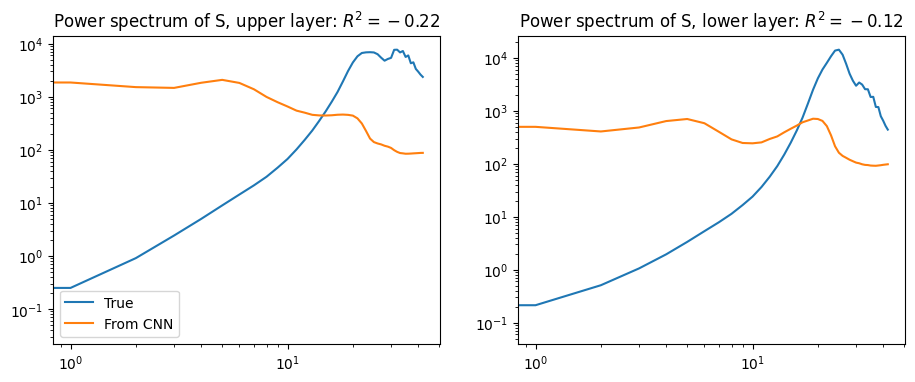

In [14]:
fig, axs = plt.subplots(1, 2,figsize=(11,4))
axs[0].set_title(r"Power spectrum of S, upper layer: $R^2=%.2f$" % r2_upper )
axs[0].loglog(power_true_upper_mean,label="True")
axs[0].loglog(power_pred_upper_mean,label="From CNN")
axs[0].legend()

axs[1].set_title(r"Power spectrum of S, lower layer: $R^2=%.2f$" % r2_lower )
axs[1].loglog(power_true_lower_mean,label="True")
axs[1].loglog(power_pred_lower_mean,label="From CNN")

figure_power=wandb.Image(fig)
wandb.log({"Power spectrum": figure_power})

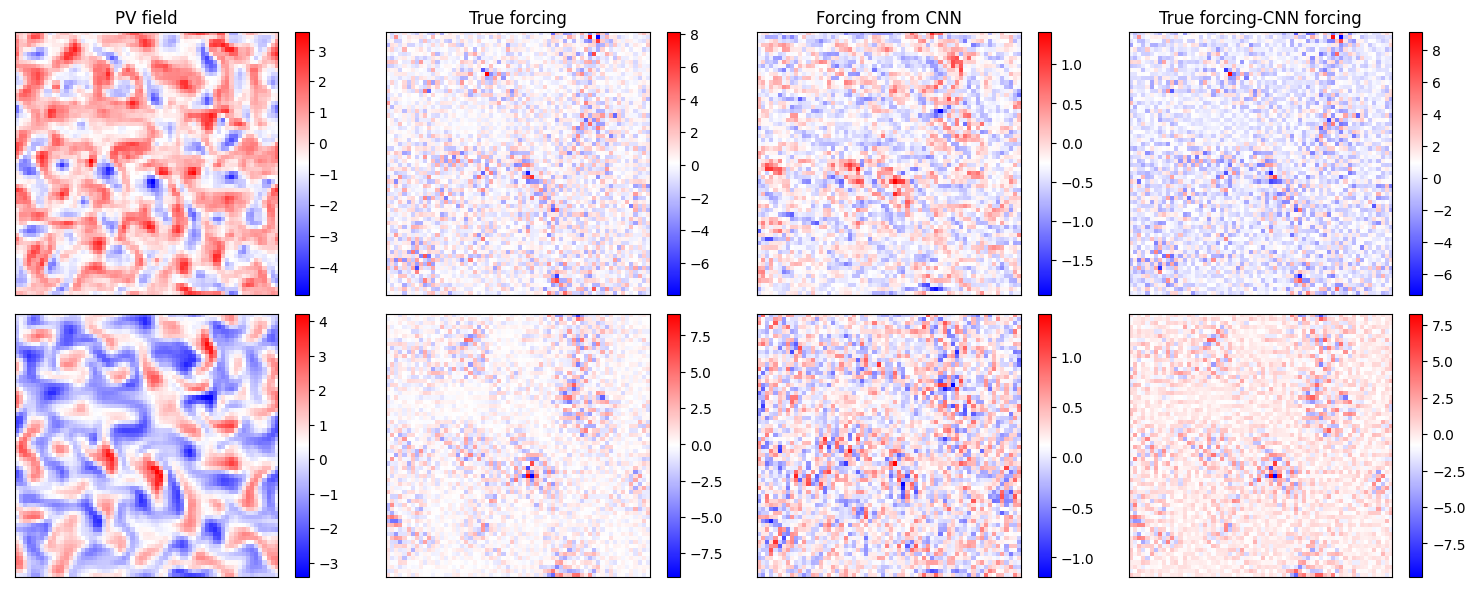

In [15]:
map_index=2

fig, axs = plt.subplots(2, 4,figsize=(15,6))
ax=axs[0][0].imshow(x_np[map_index][0], cmap='bwr')
fig.colorbar(ax, ax=axs[0][0])
axs[0][0].set_xticks([]); axs[0][0].set_yticks([])
axs[0][0].set_title("PV field")

ax=axs[0][1].imshow(y_np[map_index][0], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[0][1])
axs[0][1].set_xticks([]); axs[0][1].set_yticks([])
axs[0][1].set_title("True forcing")

ax=axs[0][2].imshow(y_pred_np[map_index][0], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[0][2])
axs[0][2].set_xticks([]); axs[0][2].set_yticks([])
axs[0][2].set_title("Forcing from CNN")

ax=axs[0][3].imshow(y_np[map_index][0]-y_pred_np[map_index][0], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[0][3])
axs[0][3].set_xticks([]); axs[0][3].set_yticks([])
axs[0][3].set_title("True forcing-CNN forcing")
fig.tight_layout()

ax=axs[1][0].imshow(x_np[map_index][1], cmap='bwr')
fig.colorbar(ax, ax=axs[1][0])
axs[1][0].set_xticks([]); axs[1][0].set_yticks([])

ax=axs[1][1].imshow(y_np[map_index][1], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[1][1])
axs[1][1].set_xticks([]); axs[1][1].set_yticks([])

ax=axs[1][2].imshow(y_pred_np[map_index][1], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[1][2])
axs[1][2].set_xticks([]); axs[1][2].set_yticks([])

ax=axs[1][3].imshow(y_np[map_index][1]-y_pred_np[map_index][1], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[1][3])
axs[1][3].set_xticks([]); axs[1][3].set_yticks([])
fig.tight_layout()

figure_fields=wandb.Image(fig)
wandb.log({"Random fields": figure_fields})

INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.92e-04, CFL: 0.235
INFO: Step: 1000, Time: 3.60e+06, KE: 5.62e-04, CFL: 0.047
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.92e-04, CFL: 0.235
INFO: Step: 1000, Time: 3.60e+06, KE: 5.28e-04, CFL: 0.042
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 6.13e-04, CFL: 0.203
INFO: Step: 1000, Time: 3.60e+06, KE: 5.90e-04, CFL: 0.044
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 6.13e-04, CFL: 0.203
INFO: Step: 1000, Time: 3.60e+06, KE: 5.46e-04, CFL: 0.047
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.70e-04, CFL: 0.231
INFO: Step: 1000, Time: 3.60e+06, KE: 5.50e-04, CFL: 0.055
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.70e-04, CFL: 0.231
INFO: Step: 1000, Time: 3.60e+06, KE: 5

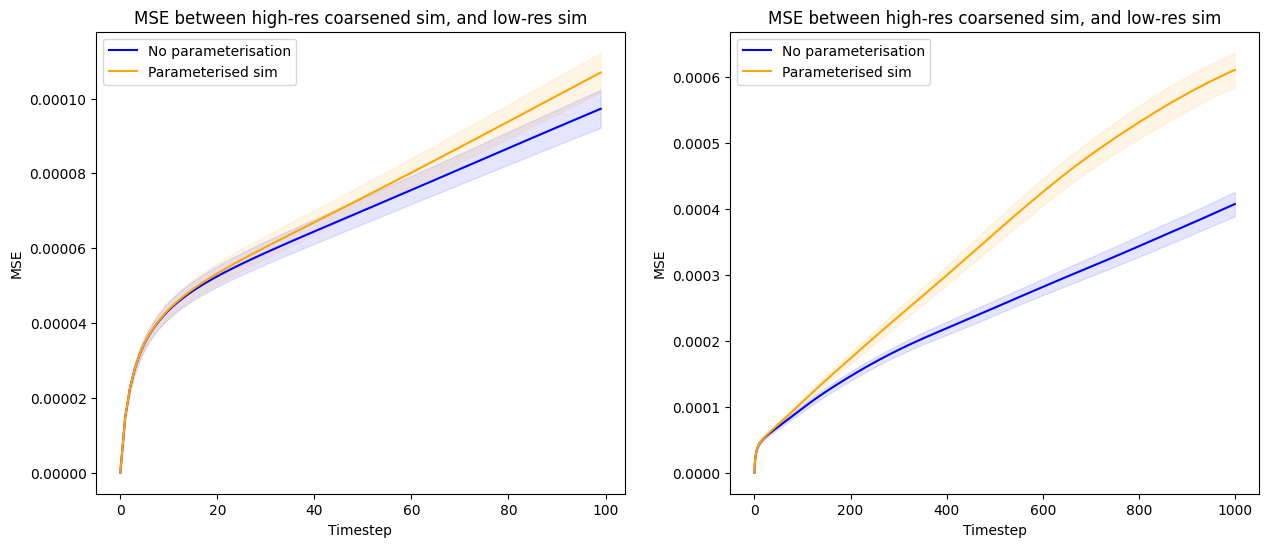

In [16]:
div_fig=divergence_dataset.test_model_divergence(model_theta)
div_fig=wandb.Image(div_fig)
wandb.log({"Divergence figure": div_fig})

In [17]:
div_fig=wandb.Image(div_fig)
wandb.log({"Divergence figure": div_fig})

In [18]:
wandb.run.summary["r2_upper"]=r2_upper
wandb.run.summary["r2_lower"]=r2_lower
wandb.finish()

epoch,▁▅█
f_lower_grad,█▂▁
f_upper_grad,█▁▁
q_lower_grad,█▂▁
q_upper_grad,█▂▁
theta_lower_grad,█▂▁
theta_upper_grad,█▂▁
training_beta_loss,█▂▁
training_loss,█▂▁
training_theta_loss,█▂▁
valid_beta_loss,█▃▁
